# _DL Model Exploration: Jan. 1, 2020_

- Primary objective --> develop language model with entire data set
- **Useful Links**
    - [Splitting data set into training and test sets using Pandas DataFrames methods](https://pythonhealthcare.org/2018/12/22/112-splitting-data-set-into-training-and-test-sets-using-pandas-dataframes-methods/)

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
# import deep learning libraries
from fastai.text import *
import torch
import fastai
from fastai import *

In [0]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

## _Set-up Directory_

In [4]:
# mount your google drive so you can save to it
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
# current directory
print('Current directory: {}'.format(os.getcwd()))

# change to appropriate directory for this project
os.chdir('/content/gdrive/My Drive/projects/Russian-Disinformation')

# ensure directory has been updated
print('Updated directory to: {}'.format(os.getcwd()))

Current directory: /content
Updated directory to: /content/gdrive/My Drive/projects/Russian-Disinformation


In [0]:
# store location of current directory
current_directory = os.getcwd()

# set up FASTAI home variable to download data to appropriate directory
os.environ['FASTAI_HOME'] = current_directory

In [7]:
from pathlib import Path

# store currect directory as  easier access
path = Path.cwd()
path

PosixPath('/content/gdrive/My Drive/projects/Russian-Disinformation')

## _Load in ALL Data_

In [0]:
ira = pd.read_json(path/"json_data/ira_train.json", orient="split")
verif = pd.read_json(path/"json_data/no_retweets.json", orient="split")

In [9]:
ira.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1525311 entries, 0 to 1525310
Data columns (total 10 columns):
id_str            1525311 non-null int64
screen_name       1525311 non-null object
created_at        1525311 non-null datetime64[ns]
lang              1525311 non-null object
source            1525311 non-null object
retweet_count     1525311 non-null int64
favorite_count    1525311 non-null int64
full_text         1525311 non-null object
clean_text        1525311 non-null object
label             1525311 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 128.0+ MB


In [0]:
# create label column (because this JSON does not have it)
verif["label"] = "real"

In [11]:
verif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211104 entries, 0 to 211103
Data columns (total 9 columns):
id_str            211104 non-null int64
screen_name       211104 non-null object
created_at        211104 non-null datetime64[ns]
lang              211104 non-null object
source            211104 non-null object
retweet_count     211104 non-null int64
favorite_count    211104 non-null int64
full_text         211104 non-null object
label             211104 non-null object
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 16.1+ MB


In [0]:
# extract relevant columns for DL
ira = ira[["full_text", "label"]].copy()
verif = verif[["full_text", "label"]].copy()

In [0]:
# grab sample same size as verif df
ira_sample = ira.sample(n=len(verif), random_state=1)

In [0]:
# combine the ira_sample and verif dfs
combined = pd.concat([verif, ira_sample])

# suffle the rows (to mix up fake/real observations)
df = combined.sample(frac=1, random_state=1).reset_index(drop=True)

# change the label column to category type
df["label"] = df["label"].astype("category")

In [15]:
# see the first few rows of df
df[:5]

,full_text,label
0,@alesiavsworld pretty,fake
1,.@SenatorSessions has a strong record when it ...,real
2,New Jersey's top court sides with Christie on ...,fake
3,"California storm brings mostly light rains, mi...",fake
4,"Life is the bitch, and death is her sister",fake


In [16]:
# check out info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422208 entries, 0 to 422207
Data columns (total 2 columns):
full_text    422208 non-null object
label        422208 non-null category
dtypes: category(1), object(1)
memory usage: 3.6+ MB


In [17]:
data_lm = (TextList.from_df(
    df=df,
    path=path,
    cols="full_text")
           .split_by_rand_pct(0.1, seed=1)
          .label_for_lm()
          .databunch(bs=48, num_workers=1)
          )

In [18]:
# see what a batch looks like
data_lm.show_batch()

idx,text
0,"is her sister xxbos xxmaj louisiana governor ' bought peace ' by paying off xxup kkk in 1960s , xxup fbi records show # politics xxbos xxmaj my statement on the passing of former xxmaj congressman xxmaj john xxmaj dingell : https : / / t.co / xxunk xxbos xxmaj perv xxunk woman inside her xxmaj west xxmaj village home : police # newyork xxbos xxup video : xxmaj thieves"
1,. xxmaj food might come second . xxmaj from the archive https : / / t.co / xxunk xxbos xxup isis invades xxmaj texas ! # texasjihad xxbos xxunk got xxup bounce 🐰 \n \n xxmaj he set the new max vert record for the xxmaj blue xxmaj devils 😈 \n \n ( via @dukembb ) \n https : / / t.co / xxunk xxbos # sanjose
2,xxbos xxmaj nice meeting with xxmaj mark xxmaj zuckerberg of @facebook in the xxmaj oval xxmaj office today . https : / / t.co / xxunk https : / / t.co / xxunk xxbos xxmaj got ta see me change xxbos xxmaj play suspended between marathon men xxmaj cilic and xxmaj isner # sports xxbos xxmaj wireless mice leave billions at risk of computer hack : cyber security firm #
3,"to xxmaj miley ’s show xxbos xxup lsu , xxmaj florida xxmaj state , xxmaj auburn stand out in mcdonogh 35 xxup dt xxmaj stephon xxmaj taylor 's top 10 # news xxbos xxup @drag0tta xxmaj lol u follow me xxrep 5 . 😂 😂 😅 xxbos xxmaj economies in southern xxmaj africa are reeling from a second historic drought in three years , leaving 45 million people facing water"
4,"trump invited — indeed , demanded — foreign involvement in our upcoming election , he struck at the very heart of what makes this a republic to which we pledge allegiance . "" https : / / t.co / 5pgb8igzpr https : / / t.co / xxunk xxbos xxmaj five prisoners scheduled to face federal executions by mid - xxmaj january . https : / / t.co / xxunk xxbos"


In [0]:
# save databunch for next time
data_lm.save("models/fulldata_lm_databunch")

## _Loading Saved Data, & Creating the Language Model_

In [0]:
data_lm = load_data(path/"models", "lm_databunch", bs=48)

In [21]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [22]:
awd = learn_lm.model[0]
enc = learn_lm.model[0].encoder
enc.weight.size()

torch.Size([47424, 400])

## _Training the Model_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


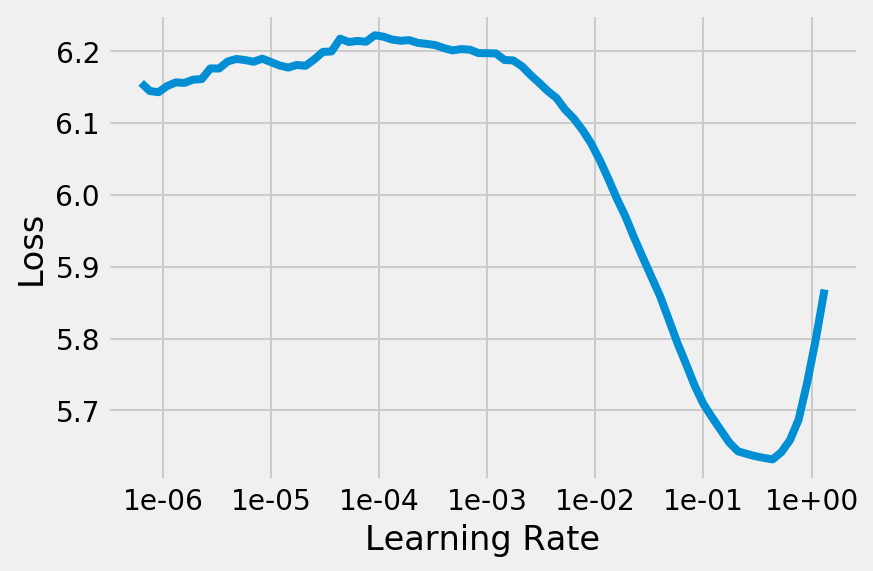

In [23]:
learn_lm.lr_find()
learn_lm.recorder.plot(skip_end=10)

In [0]:
# set learning rate
lr = 1e-2

In [0]:
# switch to mixed precision
learn_lm.to_fp16();

In [26]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.065705,3.843275,0.387829,06:22


In [0]:
learn_lm.save("fulldata_fit1");

In [0]:
learn_lm.load("fulldata_fit1");

## _Unfreeze and Fine-Tune_

In [0]:
learn_lm.unfreeze()

In [30]:
learn_lm.fit_one_cycle(10, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.504520,3.444875,0.428634,07:19
1,3.518165,3.439454,0.428920,07:18
2,3.471184,3.393681,0.433999,07:18
3,3.377995,3.315425,0.441862,07:18
4,3.270677,3.234275,0.451647,07:19
5,3.157329,3.153951,0.461114,07:19
6,3.011765,3.074659,0.471356,07:19
7,2.861548,3.012747,0.481212,07:18
8,2.695584,2.988557,0.486536,07:19
9,2.598506,2.992473,0.487110,07:19


In [0]:
learn_lm.save("fulldata_fine_tuned")

In [0]:
learn_lm.save_encoder("fulldata_fine_tuned_enc")

In [0]:
learn_lm.load("fulldata_fine_tuned");

## _Create Training Set for Classifier_

In [0]:
# create training set
train = df.sample(frac=0.8, random_state=1)

# create test set by dropping all index values associated with training sets
test = df.drop(train.index)

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337766 entries, 350281 to 351585
Data columns (total 2 columns):
full_text    337766 non-null object
label        337766 non-null category
dtypes: category(1), object(1)
memory usage: 5.5+ MB


In [58]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84442 entries, 0 to 422203
Data columns (total 2 columns):
full_text    84442 non-null object
label        84442 non-null category
dtypes: category(1), object(1)
memory usage: 1.4+ MB


In [0]:
# reset the indexes for both train and test dfs
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

## _Classifier_

In [60]:
train.columns

Index(['full_text', 'label'], dtype='object')

In [61]:
# create data object with data block API
data_clas = (TextList.from_df(
    df=train, # input training data
    path=path,
    vocab=data_lm.vocab, # load in learned vocab
    cols="full_text")
.split_by_rand_pct(0.3, seed=1)
.label_from_df(cols="label")
.databunch(bs=48, num_workers=1)
)

In [62]:
# check out training classifier
data_clas

TextClasDataBunch;

Train: LabelList (236437 items)
x: TextList
xxbos xxmaj all these news about xxmaj ukranian nuclear experiments are awful ! will you laugh now ? # xxmaj fukushima2015,xxbos https : / / t.co / xxunk https : / / t.co / xxunk,xxbos xxmaj that being said , i have a new favorite word and obsession : 
 
  ipad 
 
  ( drool ... ),xxbos xxmaj review of xxmaj capitals ' goal ignites discussion on value of coaches ' challenges # hockey,xxbos xxmaj it 's just different xxrep 4 . xxmaj the connection that i have with my fans while i 'm on that stage is unbelievable xxrep 4 . xxmaj thank you so much xxmaj irvine xxmaj ca ... xxmaj last night was epic xxrep 4 ! # irresponsibletour … https : / / t.co / xxunk
y: CategoryList
fake,real,real,fake,real
Path: /content/gdrive/My Drive/projects/Russian-Disinformation;

Valid: LabelList (101329 items)
x: TextList
xxbos a judge ’s finding of possible misconduct is likely to delay a federal execution planned for xxmaj monday https : / / t.c

In [0]:
data_clas.save("rusdis_tweet_full_class")

In [0]:
data_clas = load_data(path, "rusdis_tweet_full_class", bs=48);

In [65]:
data_clas.show_batch()

text,target
xxbos xxmaj big day ! \n \n xxmaj we ’re rolling out our next major project : a xxmaj just xxmaj society . \n \n xxmaj it ’s a xxunk suite : \n \n 1 . xxmaj recognizing xxmaj poverty xxmaj act \n 2 . xxmaj place to xxmaj prosper xxmaj act \n 3 . xxmaj mercy in xxmaj re - xxmaj entry xxmaj act,real
"xxbos xxmaj cocktails for the xxmaj revolution : \n \n - xxmaj world w / o a # greennewdeal : a xxmaj bitter xxmaj dark n ’ xxmaj stormy \n - xxmaj clean transport : an xxmaj aviation , but hold the crème de xxunk \n - xxmaj bridges , xxmaj not xxmaj walls : a xxmaj xxunk xxmaj greyhound \n - xxmaj paid xxmaj parental",real
xxbos xxmaj the latest xxmaj xxunk xxup gop conspiracy theory is that there ’s a secret “ guy who made me ” + that my male chief is “ actually ” in charge ( 🙄 ) \n \n xxmaj they got one thing right . xxmaj there is a guy who made me . \n \n xxmaj my father . \n \n xxmaj and my xxmaj papa,real
"xxbos xxmaj dem . xxmaj rep. xxmaj jim xxmaj clyburn quotes xxmaj thomas xxmaj paine : "" xxmaj tyranny , like hell , is not easily conquered . "" \n \n "" xxmaj today we have a president who seems to believe he is a king , "" xxmaj clyburn continues . "" xxmaj paine warned us that so unlimited of power can belong only to xxmaj god .",real
xxbos xxmaj just had a vision that was clear as day xxrep 4 . i m about to have one of the biggest years of my career . xxmaj mark my words people xxrep 4 . at the age 40 i feel like i 'm just getting started xxrep 4 ! i 'm about to power up & & take things to a all new level xxrep 5 ! xxmaj,real


In [66]:
data_clas

TextClasDataBunch;

Train: LabelList (236437 items)
x: TextList
xxbos xxmaj all these news about xxmaj ukranian nuclear experiments are awful ! will you laugh now ? # xxmaj fukushima2015,xxbos https : / / t.co / xxunk https : / / t.co / xxunk,xxbos xxmaj that being said , i have a new favorite word and obsession : 
 
  ipad 
 
  ( drool ... ),xxbos xxmaj review of xxmaj capitals ' goal ignites discussion on value of coaches ' challenges # hockey,xxbos xxmaj it 's just different xxrep 4 . xxmaj the connection that i have with my fans while i 'm on that stage is unbelievable xxrep 4 . xxmaj thank you so much xxmaj irvine xxmaj ca ... xxmaj last night was epic xxrep 4 ! # irresponsibletour … https : / / t.co / xxunk
y: CategoryList
fake,real,real,fake,real
Path: /content/gdrive/My Drive/projects/Russian-Disinformation;

Valid: LabelList (101329 items)
x: TextList
xxbos a judge ’s finding of possible misconduct is likely to delay a federal execution planned for xxmaj monday https : / / t.c

In [0]:
# create text classifier
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)

In [0]:
learn_c.to_fp16();

In [0]:
learn_c.load_encoder("models/fulldata_fine_tuned_enc");

In [0]:
learn_c.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


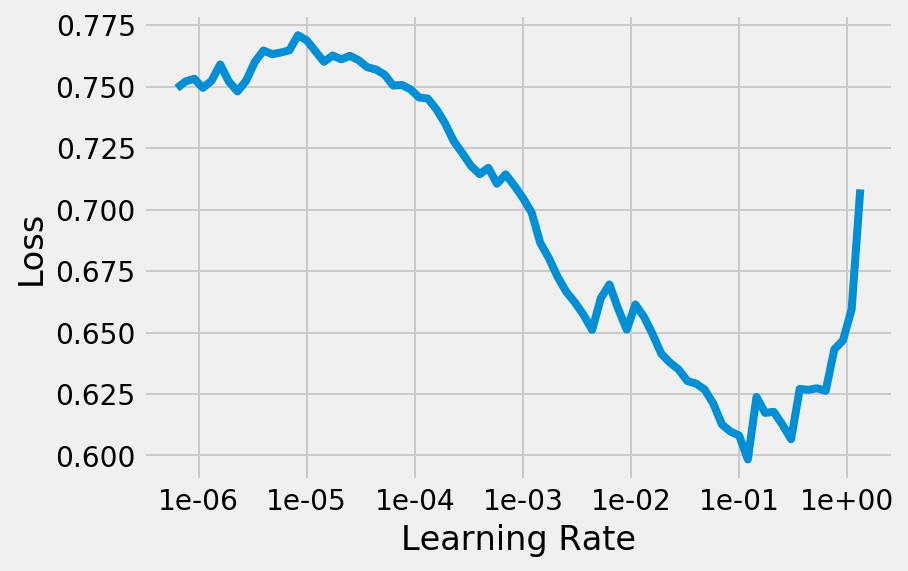

In [71]:
learn_c.lr_find()
learn_c.recorder.plot()

In [0]:
lr = 1e-3

In [73]:
learn_c.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.262060,0.160353,0.938774,02:06


In [0]:
# save weights from first round of training
learn_c.save("fulldata_first_rudis_clas")

In [0]:
# load previous weights
learn_c.load("fulldata_first_rudis_clas");

In [77]:
# second round of training
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.162322,0.118671,0.953419,02:43


In [0]:
learn_c.save("fulldata_second_rudis_clas");

In [0]:
learn_c.load("fulldata_second_rudis_clas");

In [86]:
# third round of training
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.140109,0.109819,0.957061,03:55
1,0.129417,0.112024,0.955541,03:55


In [0]:
learn_c.save("fulldata_third_rudis_clas");

In [0]:
learn_c.load("fulldata_third_rudis_clas");

In [89]:
learn_c.unfreeze()
learn_c.fit_one_cycle(3, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.133367,0.103949,0.959133,05:13
1,0.138304,0.099885,0.960485,05:20
2,0.105587,0.101518,0.959597,04:58


In [0]:
learn_c.save("fulldata_fourth_rudis_clas");

In [0]:
learn_c.load("fulldata_fourth_rudis_clas");

In [93]:
learn_c.fit_one_cycle(1, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.112969,0.101653,0.961423,05:28


In [94]:
learn_c.fit_one_cycle(1, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.100067,0.096861,0.962015,05:05


In [95]:
learn_c.fit_one_cycle(1, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.088385,0.096093,0.962271,05:21


In [0]:
learn_c.save("fulldata_final_rudis_clas")

## _Create Test Set_

In [0]:
# load in test data for IRA and Verified Users
ira_test = pd.read_json("json_data/ira_test.json", orient="split")
verif_test = pd.read_json("json_data/verified_test.json", orient="split")

In [0]:
# generate samples from both IRA and Verified test sets
ira_samp = ira_test.sample(n=400, random_state=1)
verif_samp = verif_test.sample(n=600, random_state=1)

In [0]:
combined = pd.concat([ira_samp, verif_samp])[["full_text", "label"]].sample(frac=1, random_state=1).reset_index(drop=True)

In [102]:
combined[:5]

,full_text,label
0,That’s the 3rd straight Sunday in a row I’ve c...,real
1,"""Did I look like Lamar, with that juke?""\n\n@P...",real
2,The Pensacola shooting has put a spotlight on ...,real
3,Indian army battles deadly flooding to rescue ...,fake
4,Motorcyclist Killed In Crash On Interstate 880...,fake


In [103]:
learn_c.data.classes

['fake', 'real']

In [108]:
# predict on first observation
str(learn_c.predict(combined["full_text"][0])[0])

'real'

In [0]:
# get predictions by applying predict to combine
combined["test_predict"] = combined["full_text"].apply(lambda x: str(learn_c.predict(x)[0]))

In [0]:
# convert the above to categorical type
combined["test_predict"] = combined["test_predict"].astype("category")
combined["label"] = combined["label"].astype("category")

In [117]:
combined[:5]

,full_text,label,test_predict
0,That’s the 3rd straight Sunday in a row I’ve c...,real,real
1,"""Did I look like Lamar, with that juke?""\n\n@P...",real,real
2,The Pensacola shooting has put a spotlight on ...,real,real
3,Indian army battles deadly flooding to rescue ...,fake,fake
4,Motorcyclist Killed In Crash On Interstate 880...,fake,fake


In [118]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
full_text       1000 non-null object
label           1000 non-null category
test_predict    1000 non-null category
dtypes: category(2), object(1)
memory usage: 10.1+ KB


In [121]:
import numpy as np
from sklearn.metrics import f1_score

np.mean(combined["label"] == combined["test_predict"]), f1_score(combined["label"], combined["test_predict"], pos_label="fake")

(0.974, 0.9678217821782178)

In [133]:
from tqdm import tqdm
from time import sleep

for i in tqdm(range(10)):
    sleep(1)
    pass

100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


In [0]:
def test_performance(ira_data, verif_data):
    '''
    Test text classifier N times and returns average F1 score.
    '''
    f1_dict = {}
    for n in tqdm([400, 300, 200, 100, 50]):
        f1_scores = []
        for state in tqdm([1, 5, 10, 15, 20]):
            # generate samples from both IRA and Verified test sets
            ira_samp = ira_test.sample(n=n, random_state=state)
            verif_samp = verif_test.sample(n=1000-n, random_state=state)
            # combine samples
            combined = (pd.concat([ira_samp, verif_samp])[["full_text", "label"]]
                        .sample(frac=1, random_state=1)
                        .reset_index(drop=True))
            # change label to categorical type
            combined["label"] = combined["label"].astype("category")
            # get predictions by applying predict to combine
            predictions = pd.Series(combined["full_text"].apply(lambda x: str(learn_c.predict(x)[0])), dtype="category")
            # append F1 score to list
            f1_scores.append(f1_score(combined["label"], predictions, pos_label="fake"))
        # insert F1 Scores for assigned n
        f1_dict[str(n)] = f1_scores
    # return list of f1 scores
    return f1_dict

In [135]:
%%time

f1_scores = test_performance(ira_test, verif_test)

100%|██████████| 5/5 [20:54<00:00, 250.94s/it]

CPU times: user 20min 36s, sys: 16.2 s, total: 20min 53s
Wall time: 20min 54s


In [136]:
f1_scores

{'100': [0.8767123287671232,
  0.8362068965517241,
  0.8296943231441047,
  0.8355555555555555,
  0.8622222222222223],
 '200': [0.9352517985611511,
  0.9030732860520094,
  0.908235294117647,
  0.9121140142517815,
  0.9182692307692308],
 '300': [0.957516339869281,
  0.9379084967320261,
  0.9339774557165861,
  0.9411764705882353,
  0.9477124183006537],
 '400': [0.9678217821782178,
  0.9565217391304348,
  0.9509803921568627,
  0.9542645241038319,
  0.9614906832298138],
 '50': [0.7933884297520661,
  0.7164179104477612,
  0.7022900763358778,
  0.7086614173228346,
  0.7500000000000001]}

In [139]:
for key in f1_scores.keys():
    print(f"Mean F1 Score: {np.mean(f1_scores[key])} (+/- {np.std(f1_scores[key]) * 2})")

Mean F1 Score: 0.9582158241598322 (+/- 0.011792652080620334)
Mean F1 Score: 0.9436582362413566 (+/- 0.016526817118445076)
Mean F1 Score: 0.915388724750364 (+/- 0.022206383679240625)
Mean F1 Score: 0.848078265248146 (+/- 0.036394264301390936)
Mean F1 Score: 0.7341515667717079 (+/- 0.06776172152405585)
